In [1]:
import datetime
import time
import random


import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow.compat.v1 as tf
import cv2 
tf.disable_v2_behavior()

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import normalize as nrmlz
from sklearn.utils import shuffle

from matplotlib import pyplot as plt 
from scipy import ndimage as image_tool
    

2021-11-12 15:11:22.992761: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mohy/uni/DeepLearning/HW/HW-01-DL-2021/HW1/venv/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-12 15:11:22.992782: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
np.set_printoptions(linewidth=500)

In [9]:
TRAIN_DATA_PATH = "data/Q1_train.csv"
TEST_DATA_PATH = "data/Q1_test.csv"

SIZE_IN_ROW = 28
VALIDATION_PERCNTAGE = 0.2

LABELS = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',
          12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',
          19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y'}


WIDTH = 28
HEIGHT = 28

In [10]:
all_data = pd.read_csv(TRAIN_DATA_PATH,index_col=False)
test_data = pd.read_csv(TEST_DATA_PATH,index_col=False)

In [11]:
all_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [12]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [16]:
def disp_images(data):
    fig, axes = plt.subplots(5, 5)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.5)
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i][1:].reshape(28, 28), cmap = 'binary')
        ax.set_xlabel(LABELS[data[i][0]])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.gcf().set_facecolor("white")
    plt.show()
    
    

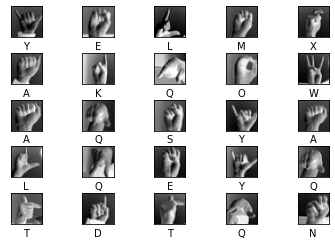

In [17]:
disp_images(all_data.iloc[0:25].values)

In [18]:
## random shuffling first time
all_data = all_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

## Train and Validation splitting

after one random shuffling , split train and validation data from all data

In [19]:
data_length = all_data.shape[0]
test_data_length = test_data.shape[0]
print("all train + validate data lengths: " + str(data_length))
validation_data_length = int(data_length * VALIDATION_PERCNTAGE)
train_data_length = data_length - validation_data_length

print("train data lengths: " + str(train_data_length) +
      "\r\nvalidate data lengths : " + str(validation_data_length))

all train + validate data lengths: 27455
train data lengths: 21964
validate data lengths : 5491


In [20]:
y_labels = all_data['label']
all_data = all_data.drop('label',1)

y_test_labels = test_data['label']
test_data = test_data.drop('label',1)


/tmp/ipykernel_7795/1524214916.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  all_data = all_data.drop('label',1)
/tmp/ipykernel_7795/1524214916.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  test_data = test_data.drop('label',1)


In [21]:
## DATA normalization and encoding Y

# x_train =  all_data.copy().values[:train_data_length].astype(np.float32)/255 
x_train = 2 * ( all_data.copy().values[:train_data_length].astype(np.float32)/255 - 0.5)
_y_train = y_labels.copy()[:train_data_length]

# x_valid =  all_data.copy().values[train_data_length:].astype(np.float32)/255  
x_valid = 2 * ( all_data.copy().values[train_data_length:].astype(np.float32)/255  - 0.5)
_y_valid = y_labels.copy().values[train_data_length:]


y_train =  tf.Session().run(tf.one_hot(_y_train,25))
y_valid =  tf.Session().run(tf.one_hot(_y_valid,25))

# x_test =  test_data.copy().values.astype(np.float32)/255  
x_test =  2 * ( test_data.copy().values.astype(np.float32)/255 - 0.5 ) 
y_test = tf.Session().run(tf.one_hot(y_test_labels.values,25))

print(x_train)
print(x_valid)
print(x_test)

2021-11-12 15:15:01.221819: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-12 15:15:01.221873: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mohy): /proc/driver/nvidia/version does not exist
2021-11-12 15:15:01.223149: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[[ 0.3411765   0.35686278  0.37254906 ...  0.7019608   0.69411767  0.6862745 ]
 [ 0.11372554  0.12941182  0.13725495 ...  0.23921573  0.2313726   0.21568632]
 [-0.1372549  -0.09803921 -0.05882353 ...  0.39607847  0.39607847  0.38823533]
 ...
 [-0.05098039  0.02745104  0.11372554 ...  0.6784314   0.69411767  0.8117647 ]
 [-0.02745098 -0.01176471  0.0196079  ...  0.03529418  0.30980396  0.43529415]
 [ 0.03529418  0.04313731  0.05882359 ...  0.56078434  0.5529412   0.5372549 ]]
[[ 0.30980396  0.30980396  0.3176471  ...  0.43529415  0.3803922   0.47450984]
 [-0.14509803 -0.0745098  -0.00392157 ... -0.19999999 -0.20784312 -0.20784312]
 [-0.02745098  0.0196079   0.06666672 ... -0.12941176 -0.12156862 -0.10588235]
 ...
 [ 0.07450986  0.09019613  0.09803927 ... -0.8901961  -0.92156863 -0.8901961 ]
 [ 0.32549024  0.33333337  0.32549024 ...  0.4039216   0.4039216   0.39607847]
 [ 0.12156868  0.13725495  0.14509809 ...  0.36470592  0.35686278  0.34901965]]
[[-0.08235294 -0.0745098  -0.06666666 ..

In [23]:
## HYPER PARAMS
adam_learning_rate = 0.001
sgd_learning_rate = 0.01
batch_size = 512
n_outputs = 25
n_inputs = x_train.shape[1]
simple_layers_num = [n_inputs,256,256,n_outputs]  ## hidden layers

In [24]:
def batch_all_data(batch_size, data, labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[: batch_size]
     # data_shuffle = [data[i] for i in idx]
    data_shuffle = np.take(data,idx,axis=0)
    # labels_shuffle = [labels[i] for i in idx]
    labels_shuffle = np.take(labels,idx,axis=0)
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


def batch_batch_data(data,labels):
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    # data_shuffle = [data[i] for i in idx]
    data_shuffle = np.take(data,idx,axis=0)
    # labels_shuffle = [labels[i] for i in idx]
    labels_shuffle = np.take(labels,idx,axis=0)
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [3]:
def path_generator(mode, layers, timestamp):
    return mode + ",".join([str(i) for i in layers[1:-1]])+" {}".format(timestamp)


In [17]:
def neural_network_simple():
    weights = []
    biases = []
    layers = []
    
    layers_num = simple_layers_num


    tf.reset_default_graph()

    X = tf.placeholder('float', [None, n_inputs],name="input")
    Y = tf.placeholder('float', [None, n_outputs],name="output")

    histogram_tensorboard = []

    print(layers_num)
    for i in range(len(layers_num)-1):
        weights.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i],layers_num[i+1]),name="W_{}".format(i),
                                       initializer=tf.glorot_normal_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("W_{}".format(i), weights[i]))

        biases.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i+1]) , name="B_{}".format(i),
                                      initializer=tf.zeros_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("B_{}".format(i), biases[i]))

    # histogram_merged = tf.summary.merge(histogram_tensorboard)

    print(weights)
    print(biases)
    middle = len(layers_num) - 3
    
    layers.append(tf.nn.relu(tf.add(tf.matmul(X, weights[0]), biases[0])))
    for i in range(middle):
        layers.append(tf.nn.relu(tf.add(tf.matmul(layers[i], weights[i+1]), biases[i+1])))

    layers.append(tf.add(tf.matmul(layers[middle], weights[middle+1]) , biases[middle+1],name="logits"))
    # layers.append(tf.matmul(layers[2], weights[3]))

    print(layers)
    return layers[-1],X,Y,histogram_tensorboard


In [5]:
def loss_accuracy_op(logits,labels,optimizer,opt_options={"learning_rate":0.001},weights=1.0):
    loss= tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=labels, logits= logits, weights=weights),name="loss")  
    _optimizer = optimizer(learning_rate = opt_options["learning_rate"])
    training_op = _optimizer.minimize(loss)
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32),name="accuracy")
    return (loss,accuracy,training_op)


def prediction(logits,sess,X,x):
    train_phase = False
    indexes = sess.run(tf.argmax(logits, 1), feed_dict={X:x})
    conf = np.take(sess.run(tf.nn.softmax(logits), feed_dict={X:x}),indexes,axis=1)
    train_phase = True
    return indexes, conf

In [19]:
def tensorboard_creator(loss,accuracy,histogram):
    
    loss_tensorboard=tf.summary.scalar('Validation_Loss', loss)
    acc_tensorboard=tf.summary.scalar('Validation_Accuracy', accuracy)
    
    train_tensorboard=tf.summary.scalar('Training_Loss', loss)

    merged = tf.summary.merge([loss_tensorboard,acc_tensorboard] + histogram)
    return merged, train_tensorboard



In [20]:

def train_task(summary_path,train_data,validate_data,batch_size,loss,accuracy,
               training_op,epoches,train_tensorboard,merged_tensorboard,X,Y):
    
    loss_buffer = []
    acc_buffer = []
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        write = tf.summary.FileWriter(summary_path, sess.graph)

        sess.run(tf.global_variables_initializer())
        t = time.time()
        for epoch in range(0,epoches):
            train_phase = True

            for i in range(int(train_data_length/batch_size)):
                
                input_shuffle, output_shuffle = batch_batch_data(train_data[0][i*batch_size : (i+1)*batch_size],
                                                                 train_data[1][i*batch_size : (i+1)*batch_size])
                f = { X: input_shuffle, Y: output_shuffle }
                
                _, train_val = sess.run([training_op, train_tensorboard],feed_dict=f)
                
                write.add_summary(train_val,epoch * int(train_data_length/batch_size) + i)

              # print('iter {}: \t Loss={:.2f}'.format(i,sess.run(loss,feed_dict=f)))

            f_valid={X:validate_data[0], Y:validate_data[1]}
            train_phase = False

            val,ls,acc = sess.run([merged_tensorboard,loss,accuracy], feed_dict=f_valid)
            write.add_summary(val,epoch)
            # write.add_summary(acc,epoch)
            if epoch%10 == 0:
                print('--------------------------------------------------')
                print('Epoch:{} \t Validation Loss:{:.2f} , acc: {:.2f}'.format(epoch,ls,acc))
                print('--------------------------------------------------')
            loss_buffer.append(ls)
            acc_buffer.append(acc)
        
        train_phase = False
        ls,acc = sess.run([loss,accuracy],feed_dict={X:x_test,Y:y_test})
        print('--------------------------------------------------')
        print('final \t test Loss:{:.2f} , acc: {:.2f}'.format(ls,acc))
        print('--------------------------------------------------')
        print('time = ', time.time()-t)
        print(summary_path)
        save_path = saver.save(sess, summary_path.replace("summary","model"))
        print("Model saved in path: %s" % save_path)
        return loss_buffer,acc_buffer



In [671]:
timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()[5:-3]

logits, input_data, out, histogram_tensorboard = neural_network_simple()
SGD_loss,SGD_accuracy,SGD_training_op = loss_accuracy_op(logits,out,tf.train.GradientDescentOptimizer,{"learning_rate":sgd_learning_rate})
SGD_merged,SGD_train_tensorboard = tensorboard_creator(SGD_loss,SGD_accuracy,histogram_tensorboard)
ls_sgd, acc_sgd = train_task(path_generator("./summary/SGD/simple/", simple_layers_num, timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           SGD_loss,SGD_accuracy,SGD_training_op,120,SGD_train_tensorboard,SGD_merged, input_data, out);

logits, input_data, out, histogram_tensorboard = neural_network_simple()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task(path_generator("./summary/Adam/simple/", simple_layers_num, timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,50,Adam_train_tensorboard,Adam_merged, input_data, out);



[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'logits:0' shape=(?, 25) dtype=float32>]
--------------------------------------------------
Epoch:0 	 Validation Loss:2.92 , acc: 0.25
--------------------------------------------------
--------------------------------------------------
Epoch:10 	 Validation Loss:1.11 , acc: 0.73
--------------------------------------------------
--------------------------------------------------
Epoch:20 	 Validation Loss:0.63 , acc: 0.86
--------------------------------------------------
--------------------------------------------------

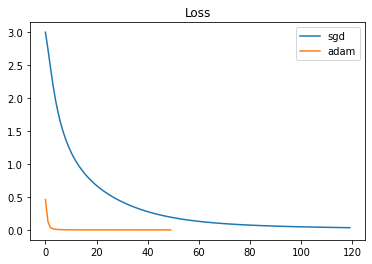

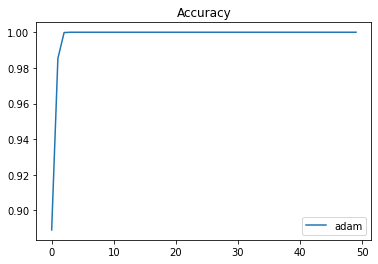

In [358]:
plt.plot(list(range(len(ls_sgd))),ls_sgd,label = "sgd")
plt.plot(list(range(len(ls_adam))),ls_adam,label = "adam")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure()

# plt.plot(list(range(len(acc_sgd))),acc_sgd,label = "sgd")
plt.plot(list(range(len(acc_adam))),acc_adam,label = "adam")
plt.title("Accuracy")
plt.legend()
plt.show()

In [4]:
def load_model(path, sess):
    
    saver = tf.train.import_meta_graph(path+".meta")

    graph = tf.get_default_graph()

    Logits = graph.get_tensor_by_name("logits:0")

    input_d = graph.get_tensor_by_name("input:0")
    out_d = graph.get_tensor_by_name("output:0")

    Loss = graph.get_tensor_by_name("loss:0")

    Accuracy = graph.get_tensor_by_name("accuracy:0")
    
    saver.restore(sess, path)    
    
    return Logits, input_d, out_d, Loss, Accuracy


INFO:tensorflow:Restoring parameters from ./model/Adam/simple/256,256 11-11T18:42
0.82 1.14


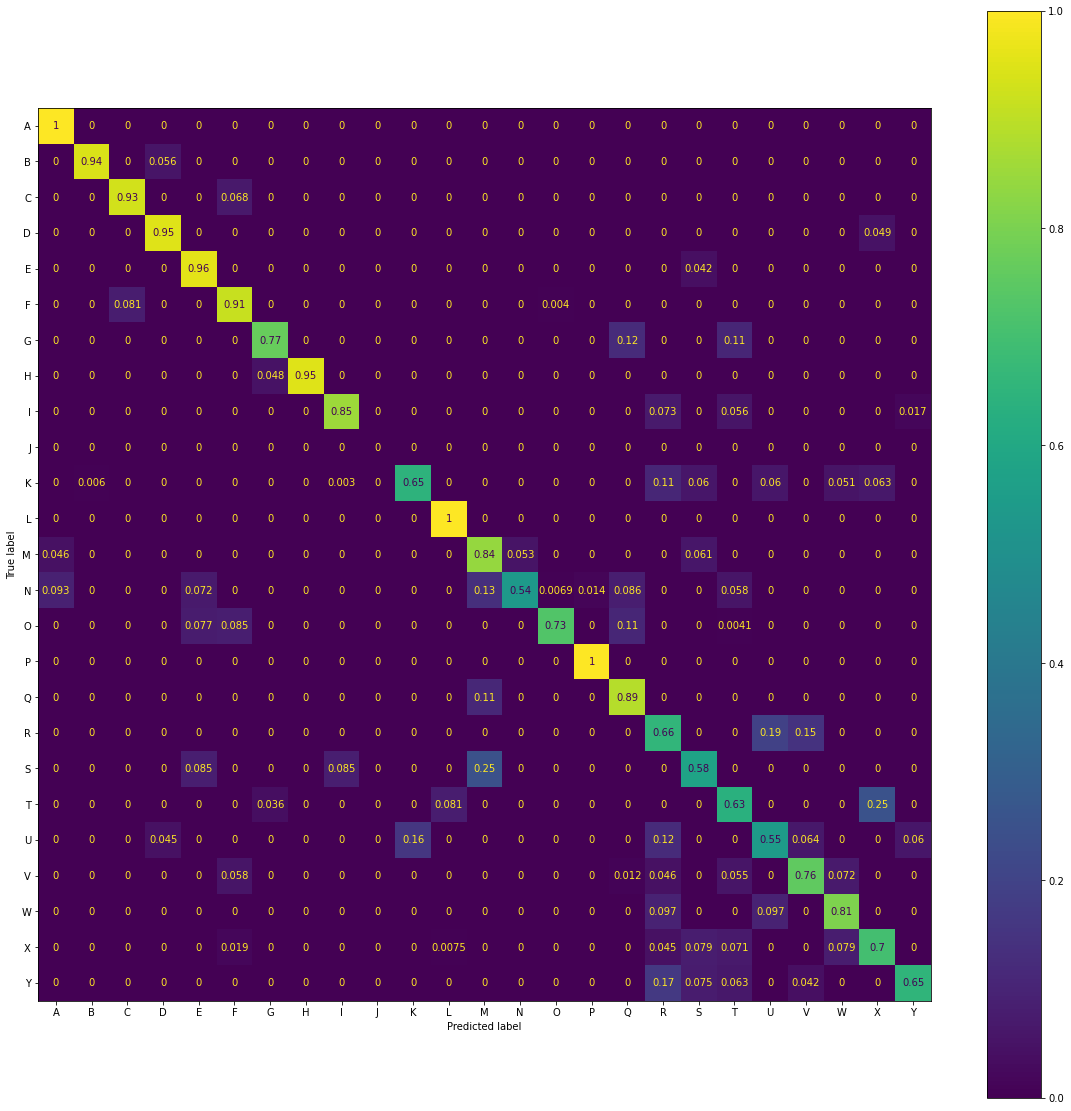

In [376]:
## test of model after save
simple_path = path_generator("./model/Adam/simple/",simple_layers_num,timestamp)

tf.reset_default_graph()

with tf.Session() as sess:
  # Restore variables from disk.
    Logits, input_d, out_d, Loss, Accuracy = load_model(simple_path,sess)
    
    ls,acc = sess.run([Loss,Accuracy],feed_dict={input_d:x_test,out_d:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(nrmlz(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(Logits,sess,input_d,x_test)[0])),axis=1,norm="l1"),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

INFO:tensorflow:Restoring parameters from ./model/SGD/simple/256,256 11-11T18:42
0.77 0.88


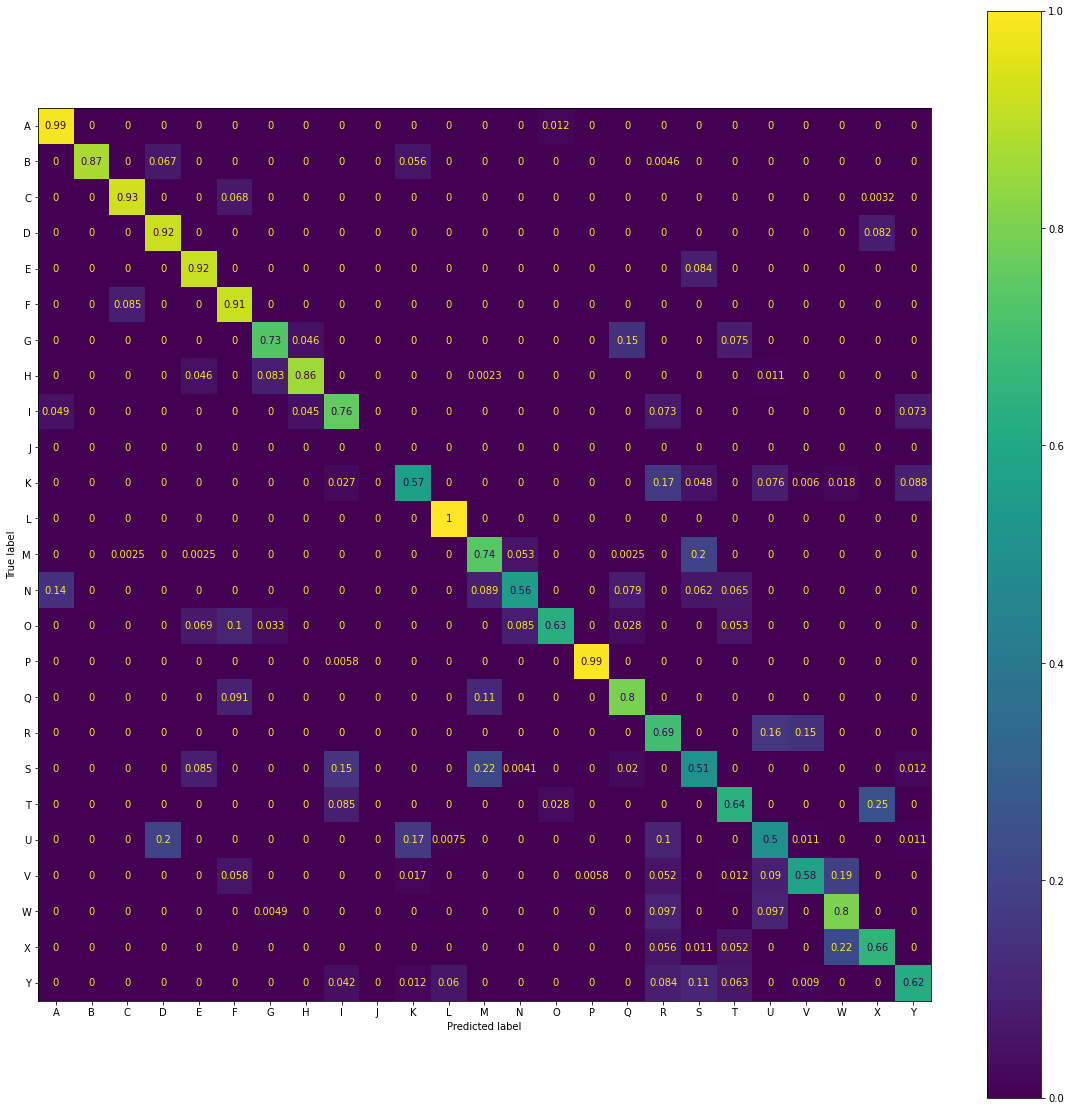

In [356]:
## test of model after save
simple_path = path_generator("./model/SGD/simple/",simple_layers_num,timestamp)

tf.reset_default_graph()

with tf.Session() as sess:
  # Restore variables from disk.
    Logits, input_d, out_d, Loss, Accuracy = load_model(simple_path,sess)
    
    ls,acc = sess.run([Loss,Accuracy],feed_dict={input_d:x_test,out_d:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(nrmlz(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(Logits,sess,input_d,x_test)[0])),axis=1,norm="l1"),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

In [360]:
## HYPER PARAMS
adam_learning_rate = 0.001
batch_size = 256
n_inputs = x_train.shape[1]
n_outputs = 25
dropout_layers_num = [n_inputs,256,256,n_outputs] ## hidden layers

In [367]:
def neural_network_with_dropout():
    weights = []
    biases = []
    layers = []

    layers_num = dropout_layers_num
    
    tf.reset_default_graph()

    X = tf.placeholder('float', [None, n_inputs],name="input")
    Y = tf.placeholder('float', [None, n_outputs],name="output")

    histogram_tensorboard = []

    print(layers_num)
    
    for i in range(len(layers_num)-1):
        weights.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i],layers_num[i+1]),name="W_{}".format(i),
                                       initializer=tf.glorot_normal_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("W_{}".format(i), weights[i]))

        biases.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i+1]) , name="B_{}".format(i),
                                      initializer=tf.glorot_normal_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("B_{}".format(i), biases[i]))
    
    
    print(weights)
    print(biases)
    middle = len(layers_num) - 3
    
    layers.append(tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(X, weights[0]), biases[0])), rate = 0.3))
    for i in range(middle):
        layers.append(tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(layers[i], weights[i+1]), biases[i+1])), rate = 0.3))
    
    layers.append(tf.add(tf.matmul(layers[middle], weights[middle+1]) , biases[middle+1],name="logits"))
    
    
    print(layers)
    return layers[-1],X,Y,histogram_tensorboard

In [368]:
do_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()[5:-3]

logits, input_data, out, histogram_tensorboard = neural_network_with_dropout()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task(path_generator("./summary/Adam/dropout/",dropout_layers_num,do_timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,50,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'dropout/Mul_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'dropout_1/Mul_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'logits:0' shape=(?, 25) dtype=float32>]
--------------------------------------------------
Epoch:0 	 Validation Loss:0.89 , acc: 0.72
--------------------------------------------------
--------------------------------------------------
Epoch:10 	 Validation Loss:0.03 , acc: 0.99
--------------------------------------------------
--------------------------------------------------
Epoch:20 	 Validation Loss:0.02 , acc: 0.99
--------------------------------------------------
--------------------------------

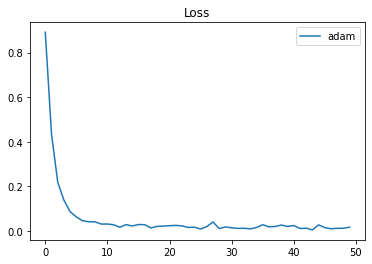

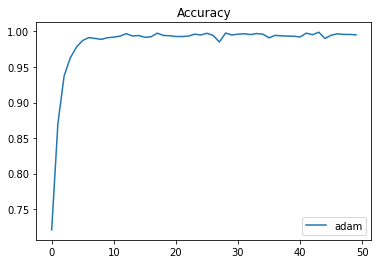

In [369]:
plt.plot(list(range(len(ls_adam))),ls_adam,label = "adam")
plt.title("Loss")
plt.legend()
plt.show()


plt.plot(list(range(len(acc_adam))),acc_adam,label = "adam")
plt.title("Accuracy")
plt.legend()
plt.show()

INFO:tensorflow:Restoring parameters from ./model/Adam/dropout/512,256 11-11T16:57
0.77 1.14


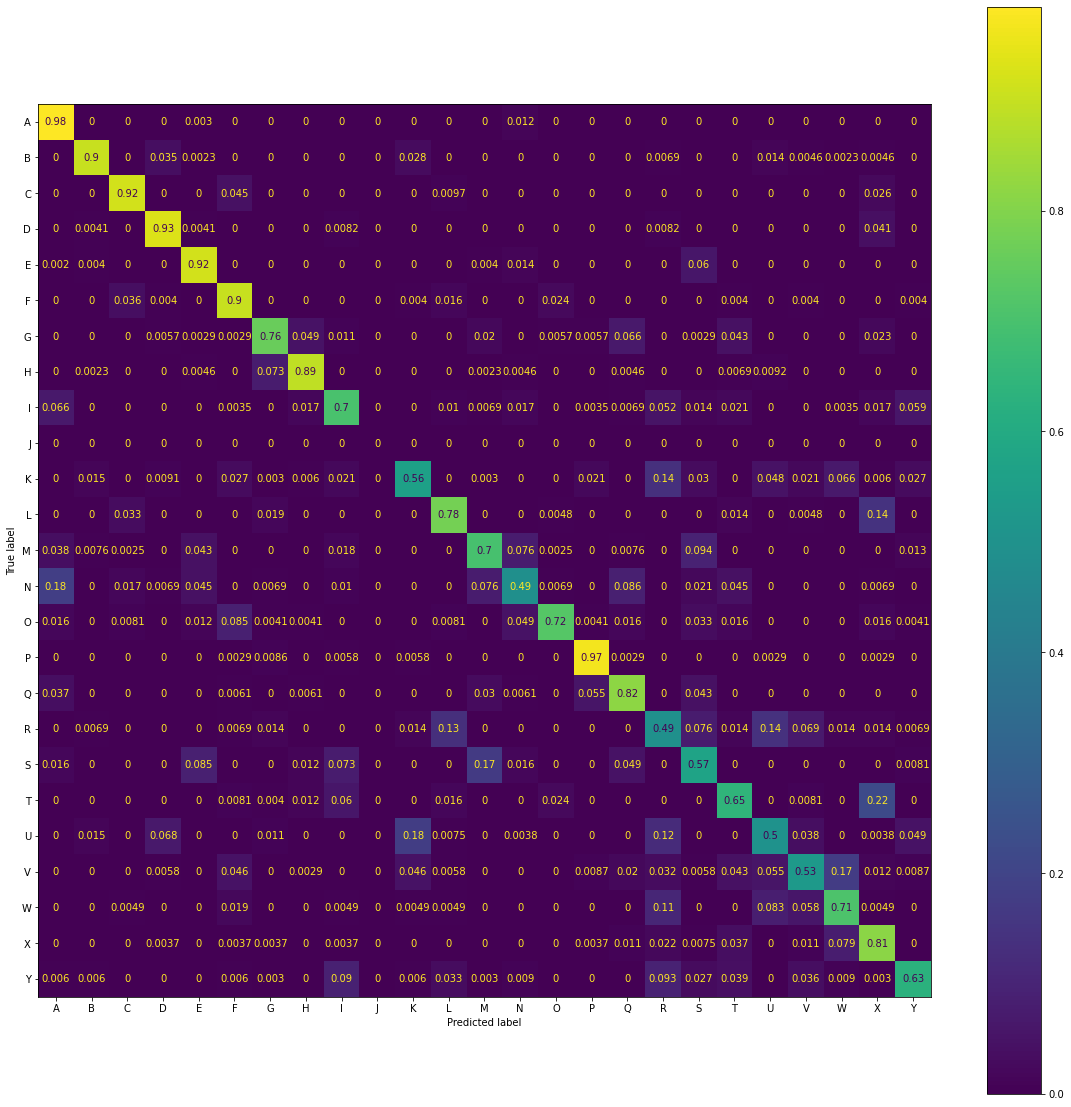

In [192]:
## test of model after save
do_path = path_generator("./model/Adam/dropout/", dropout_layers_num,do_timestamp)

tf.reset_default_graph()

with tf.Session() as sess:
  # Restore variables from disk.
    Logits, input_d, out_d, Loss, Accuracy = load_model(do_path,sess)
    
    ls,acc = sess.run([Loss,Accuracy],feed_dict={input_d:x_test,out_d:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(nrmlz(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(Logits,sess,input_d,x_test)[0])),axis=1,norm="l1"),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

In [31]:
## HYPER PARAMS
adam_learning_rate = 0.001

batch_size = 256
n_inputs = x_train.shape[1]
n_outputs = 25
BN_layers_num = [n_inputs,256,256,n_outputs] ## hidden layers

train_phase = False

In [32]:
def neural_network_with_BN():
    weights = []
    biases = []
    layers = []
    
    layers_num = BN_layers_num

    tf.reset_default_graph()


    X = tf.placeholder('float', [None, n_inputs],name="input")
    Y = tf.placeholder('float', [None, n_outputs],name="output")

    histogram_tensorboard = []

    print(layers_num)
    for i in range(len(layers_num)-1):
        weights.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i],layers_num[i+1]),name="W_{}".format(i),
                                       initializer=tf.glorot_normal_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("W_{}".format(i), weights[i]))
        
        biases.append(tf.get_variable(dtype=tf.float32, shape=(layers_num[i+1]) , name="B_{}".format(i),
                                      initializer=tf.zeros_initializer()))
        histogram_tensorboard.append(tf.summary.histogram("B_{}".format(i), biases[i]))

    # histogram_merged = tf.summary.merge(histogram_tensorboard)

    print(weights)
    print(biases)
    middle = len(layers_num) - 3
    
    layers.append(tf.nn.relu(tf.layers.batch_normalization(tf.add(tf.matmul(X, weights[0]), biases[0]), training = train_phase)))
    
    for i in range(middle):
        layers.append(tf.nn.relu(tf.layers.batch_normalization(tf.add(tf.matmul(layers[i], weights[i+1]), biases[i+1]), training = train_phase)))

    layers.append(tf.add(tf.matmul(layers[middle], weights[middle+1]) , biases[middle+1],name="logits"))


    print(layers)
    return layers[-1],X,Y,histogram_tensorboard

In [33]:
bn_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()[5:-3]

logits, input_data, out, histogram_tensorboard = neural_network_with_BN()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
bn_ls_adam, bn_acc_adam = train_task(path_generator("./summary/Adam/batchnormal/", BN_layers_num, bn_timestamp),(x_train,y_train),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,50,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]


/home/mohy/uni/DeepLearning/HW/HW-01-DL-2021/HW1/venv/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/mohy/uni/DeepLearning/HW/HW-01-DL-2021/HW1/venv/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'logits:0' shape=(?, 25) dtype=float32>]
--------------------------------------------------
Epoch:0 	 Validation Loss:0.46 , acc: 0.89
--------------------------------------------------
--------------------------------------------------
Epoch:10 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------
Epoch:20 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------
Epoch:30 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------
Epoch:40 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------
final 	 test Loss:1.23 , acc: 0.81
----------------------------

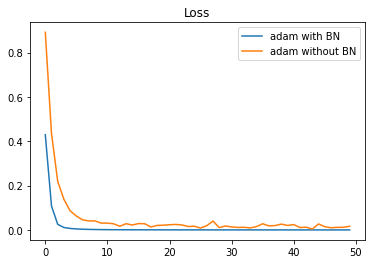

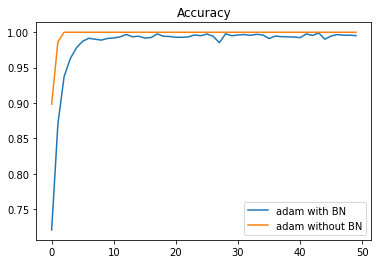

In [374]:
plt.plot(list(range(len(bn_ls_adam))),bn_ls_adam,label = "adam with BN")
# plt.plot(list(range(len(ls_adam))),ls_adam,label = "adam without BN")
plt.title("Loss")
plt.legend()
plt.show()


plt.plot(list(range(len(acc_adam))),acc_adam,label = "adam with BN")
# plt.plot(list(range(len(bn_acc_adam))),bn_acc_adam,label = "adam without BN")
plt.title("Accuracy")
plt.legend()
plt.show()


INFO:tensorflow:Restoring parameters from ./model/Adam/batchnormal/256,256 11-12T00:50
0.81 1.23


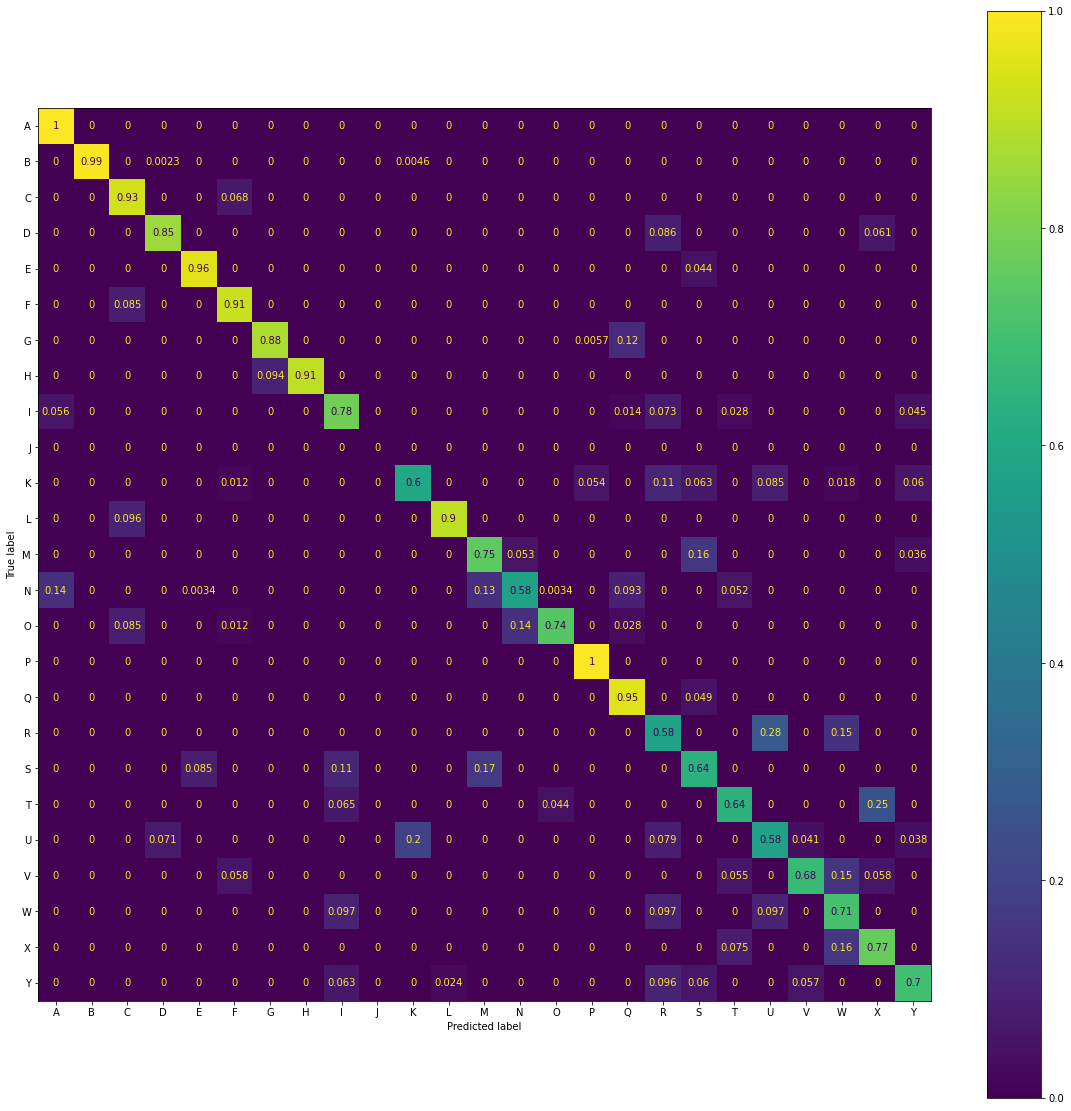

In [36]:
## test of model after save
bn_path = path_generator("./model/Adam/batchnormal/",BN_layers_num,bn_timestamp)

tf.reset_default_graph()

with tf.Session() as sess:
  # Restore variables from disk.
    Logits, input_d, out_d, Loss, Accuracy = load_model(bn_path, sess)
    
    ls,acc = sess.run([Loss,Accuracy],feed_dict={input_d:x_test,out_d:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(nrmlz(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(Logits,sess,input_d,x_test)[0])),axis=1,norm="l1"),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

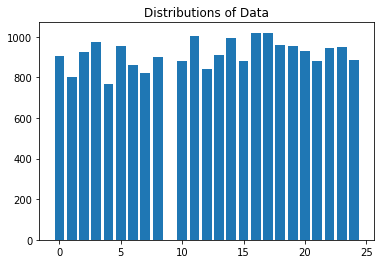

In [154]:
counters = np.zeros(25)
A_index = []
for i in range(x_train.shape[0]):
    counters += y_train[i]
    if np.argmax(y_train[i]) == 0: ## class A
        A_index.append(i)
plt.bar([i for i in range(25)], counters)
plt.title("Distributions of Data")
plt.show()

In [155]:
idx = np.sort(random.sample(range(len(A_index)), int(len(A_index) * 4 / 5)))
A_in = np.take(A_index, idx, axis = 0)
x_subsample = np.delete(x_train, A_in, axis=0)
y_subsample = np.delete(y_train, A_in, axis=0)

        

(722,)
(21964, 784)
(21242, 784)
(21242, 25)


In [157]:
ss_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()[5:-3]

logits, input_data, out, histogram_tensorboard = neural_network_simple()
Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task(path_generator("./summary/Adam/subsample/", simple_layers_num, ss_timestamp),(x_subsample,y_subsample),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,50,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'logits:0' shape=(?, 25) dtype=float32>]
--------------------------------------------------
Epoch:0 	 Validation Loss:0.61 , acc: 0.83
--------------------------------------------------
--------------------------------------------------
Epoch:10 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------
Epoch:20 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------

INFO:tensorflow:Restoring parameters from ./model/Adam/subsample/256,256 11-12T01:23


INFO:tensorflow:Restoring parameters from ./model/Adam/subsample/256,256 11-12T01:23


0.80 1.18


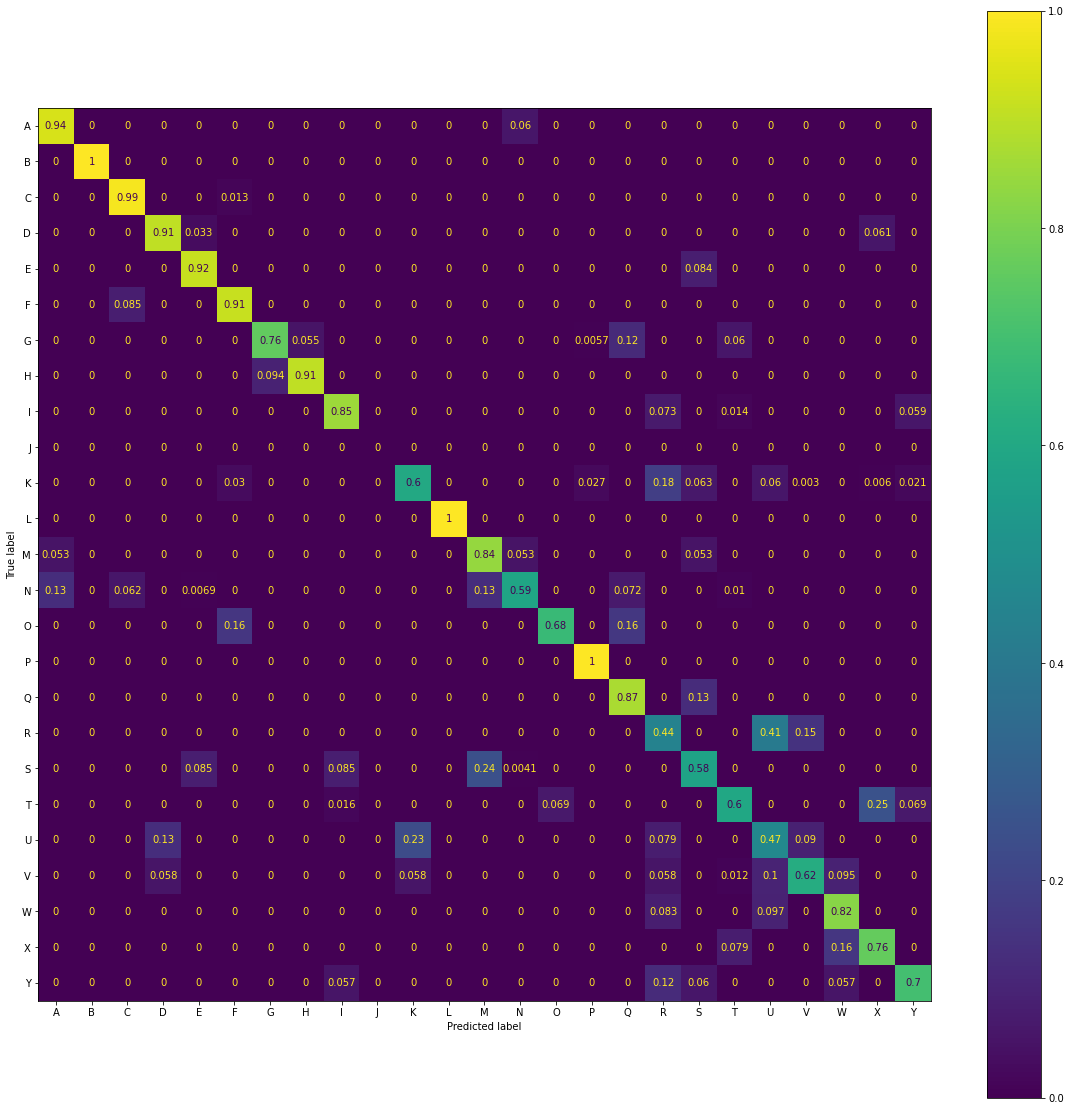

In [158]:
## test of model after save
ss_path = path_generator("./model/Adam/subsample/",simple_layers_num,ss_timestamp)

tf.reset_default_graph()

with tf.Session() as sess:
  # Restore variables from disk.
    Logits, input_d, out_d, Loss, Accuracy = load_model(ss_path, sess)
    
    ls,acc = sess.run([Loss,Accuracy],feed_dict={input_d:x_test,out_d:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(nrmlz(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(Logits,sess,input_d,x_test)[0])),axis=1,norm="l1"),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

In [159]:
def augment(xdata, ydata):
    buffer = []
    y_buffer = []
    for j in range(xdata.shape[0]):
        if LABELS[np.argmax(ydata[j])] not in ["A"]:
            continue
        d = xdata[j]
        for i in range(1):
            y_buffer.append(ydata[j])
            buffer.append(cv2.resize(image_tool.rotate(d.reshape(28,28),np.random.randint(-5,5,1)[0]),(28,28)).flatten())
            
            
        buffer.append(cv2.convertScaleAbs(d, alpha=1.5, beta=0).flatten())
        y_buffer.append(ydata[j])
    return buffer, y_buffer

In [160]:
_x, _y = augment(x_train,y_train)
augmented_xdata = np.array(_x)
augmented_ydata = np.array(_y)

In [161]:
x_aug = np.concatenate((augmented_xdata,x_subsample), axis=0)
y_aug = np.concatenate((augmented_ydata,y_subsample), axis=0)

randomize = np.arange(x_aug.shape[0])
np.random.shuffle(randomize)

x_aug = x_aug[randomize]
y_aug = y_aug[randomize]


In [164]:
aa_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()[5:-3]
logits, input_data, out, histogram_tensorboard = neural_network_simple()

Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate})
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task(path_generator("./summary/Adam/augment/", simple_layers_num, aa_timestamp),(x_aug, y_aug),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,50,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'logits:0' shape=(?, 25) dtype=float32>]
--------------------------------------------------
Epoch:0 	 Validation Loss:0.50 , acc: 0.89
--------------------------------------------------
--------------------------------------------------
Epoch:10 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------
Epoch:20 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------

INFO:tensorflow:Restoring parameters from ./model/Adam/augment/256,256 11-12T01:36


INFO:tensorflow:Restoring parameters from ./model/Adam/augment/256,256 11-12T01:36


0.81 1.07


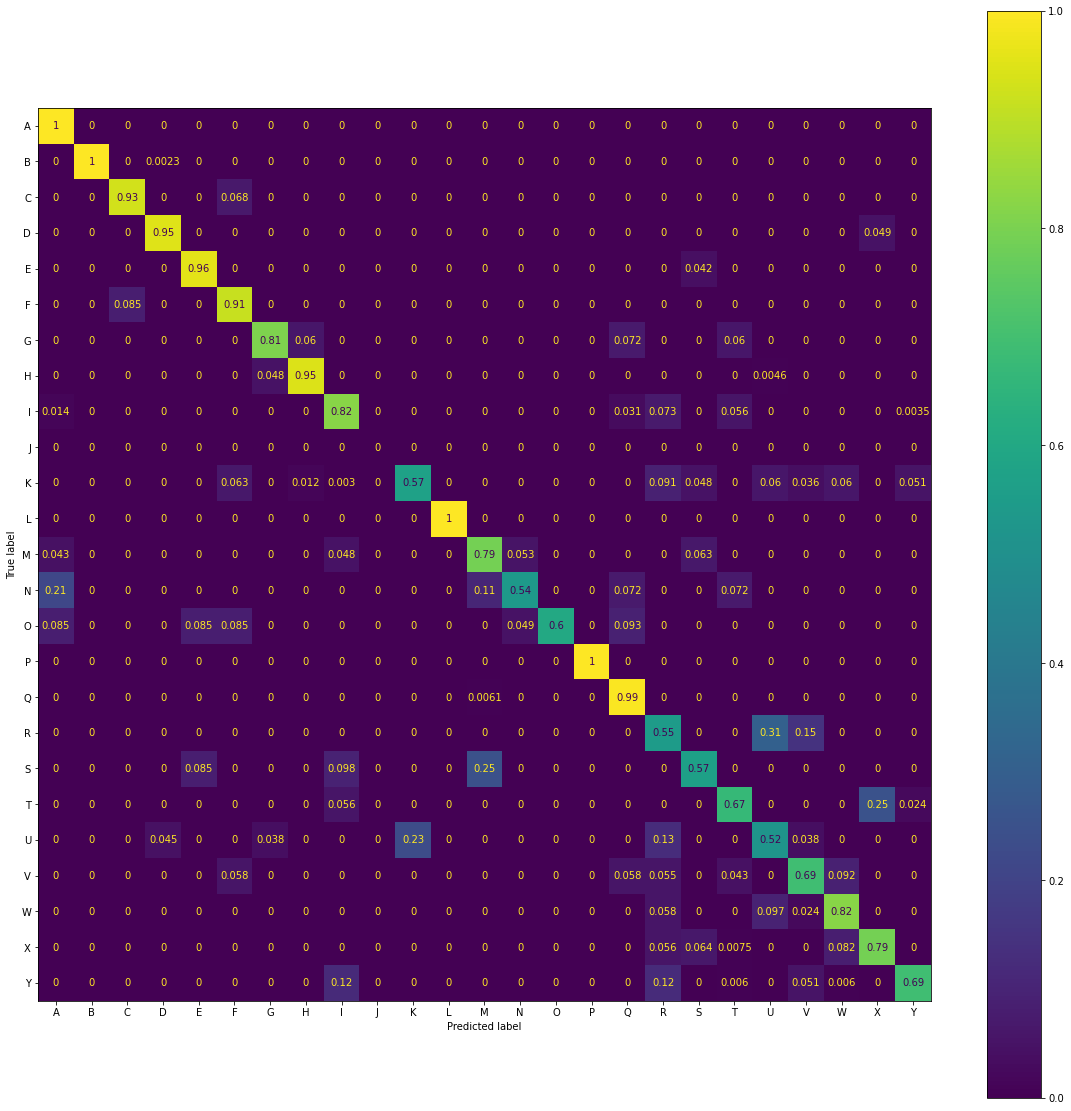

In [165]:
## test of model after save
ss_path = path_generator("./model/Adam/augment/",simple_layers_num,aa_timestamp)

tf.reset_default_graph()

with tf.Session() as sess:
  # Restore variables from disk.
    Logits, input_d, out_d, Loss, Accuracy = load_model(ss_path, sess)
    
    ls,acc = sess.run([Loss,Accuracy],feed_dict={input_d:x_test,out_d:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(nrmlz(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(Logits,sess,input_d,x_test)[0])),axis=1,norm="l1"),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

In [167]:
class_weights = [4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]

aa_timestamp = datetime.datetime.now().replace(microsecond=0).isoformat()[5:-3]
logits, input_data, out, histogram_tensorboard = neural_network_simple()
weights = tf.reduce_sum(tf.constant(class_weights) * out, axis=1)

Adam_loss,Adam_accuracy,Adam_training_op = loss_accuracy_op(logits, out, tf.train.AdamOptimizer, {"learning_rate":adam_learning_rate}, weights)
Adam_merged,Adam_train_tensorboard = tensorboard_creator(Adam_loss, Adam_accuracy, histogram_tensorboard)
ls_adam, acc_adam = train_task(path_generator("./summary/Adam/augment/", simple_layers_num, aa_timestamp),(x_subsample, y_subsample),(x_valid,y_valid),batch_size,
           Adam_loss,Adam_accuracy,Adam_training_op,50,Adam_train_tensorboard,Adam_merged, input_data, out);

[784, 256, 256, 25]
[<tf.Variable 'W_0:0' shape=(784, 256) dtype=float32_ref>, <tf.Variable 'W_1:0' shape=(256, 256) dtype=float32_ref>, <tf.Variable 'W_2:0' shape=(256, 25) dtype=float32_ref>]
[<tf.Variable 'B_0:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_1:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'B_2:0' shape=(25,) dtype=float32_ref>]
[<tf.Tensor 'Relu:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'Relu_1:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'logits:0' shape=(?, 25) dtype=float32>]
--------------------------------------------------
Epoch:0 	 Validation Loss:0.66 , acc: 0.85
--------------------------------------------------
--------------------------------------------------
Epoch:10 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------
Epoch:20 	 Validation Loss:0.00 , acc: 1.00
--------------------------------------------------
--------------------------------------------------

INFO:tensorflow:Restoring parameters from ./model/Adam/augment/256,256 11-12T01:38


INFO:tensorflow:Restoring parameters from ./model/Adam/augment/256,256 11-12T01:38


0.80 1.18


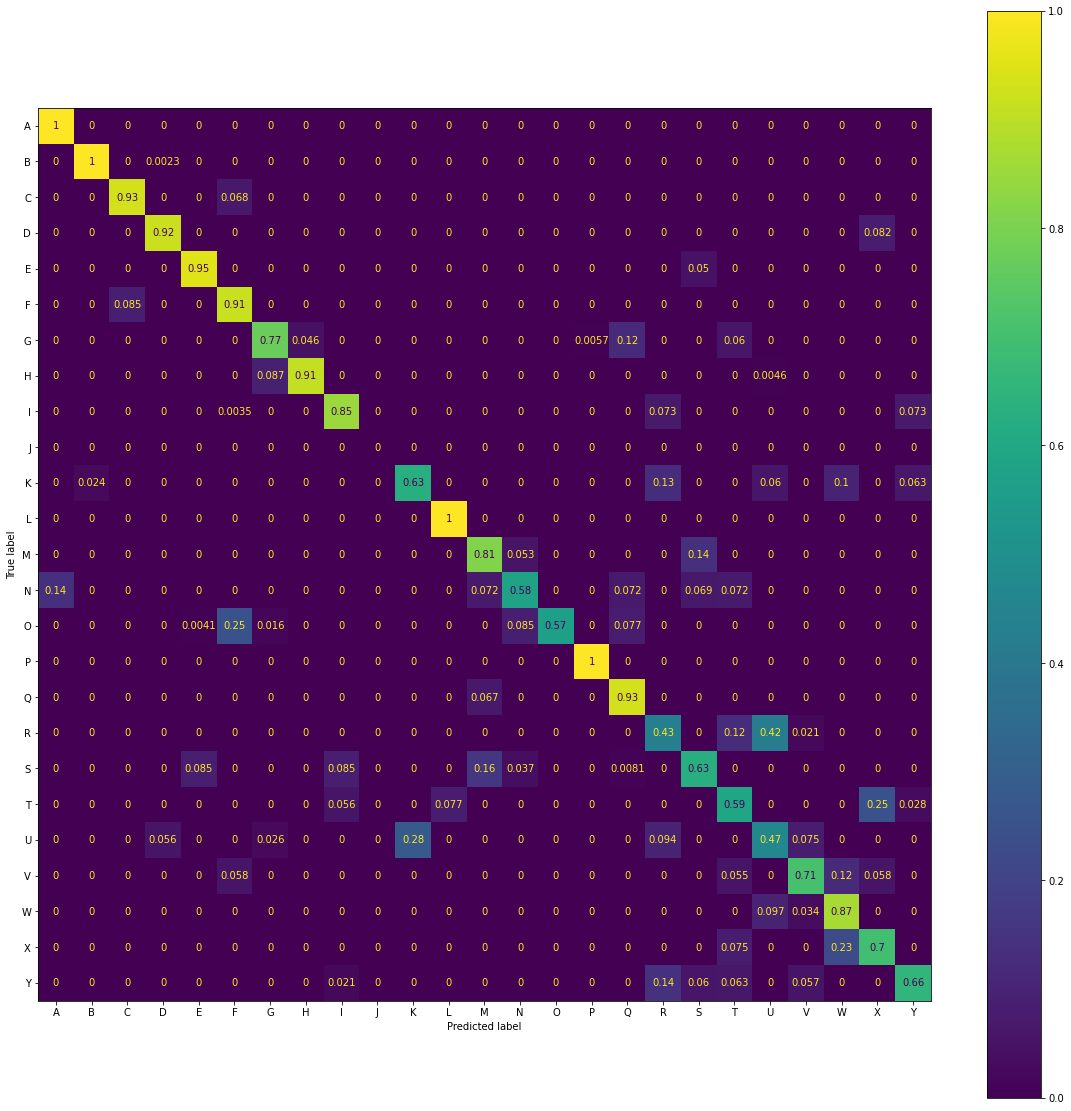

In [168]:
## test of model after save
aa_path = path_generator("./model/Adam/augment/", simple_layers_num, aa_timestamp)

tf.reset_default_graph()

with tf.Session() as sess:
  # Restore variables from disk.
    Logits, input_d, out_d, Loss, Accuracy = load_model(aa_path, sess)
    
    ls,acc = sess.run([Loss,Accuracy],feed_dict={input_d:x_test,out_d:y_test})
    print("{:.2f}".format(acc),"{:.2f}".format(ls))
    disp = ConfusionMatrixDisplay(nrmlz(sess.run(tf.math.confusion_matrix(y_test_labels.values,prediction(Logits,sess,input_d,x_test)[0])),axis=1,norm="l1"),display_labels=LABELS.values())
    fig, ax = plt.subplots(figsize=(20,20))
    disp.plot(ax=ax)
    
    

In [28]:

def live(model):
    mpHands = mp.solutions.hands
    hands = mpHands.Hands(static_image_mode=False,
                          max_num_hands=1,
                          min_detection_confidence=0.5,
                          min_tracking_confidence=0.5)

    mpDraw = mp.solutions.drawing_utils

    W = 320
    H = 240

    font                   = cv2.FONT_HERSHEY_SIMPLEX
    fontScale              = 0.5
    fontColor              = (255,255,255)
    lineType               = 2

    tf.reset_default_graph()

    boundary = 20

    # saver = tf.train.Saver()

    with tf.Session().as_default() as sess:
      # Restore variables from disk.
        logits, input_data, out, Loss, Accuracy = load_model(model, sess)
    
        cam = cv2.VideoCapture(0)
        print("press ESC to exit")
        try:
            while True:
                ret_val, img = cam.read()
                img = cv2.resize(img, (W,H))        
                results = hands.process(img)

                if results.multi_hand_landmarks:
                    for handLms in results.multi_hand_landmarks:
                        x_max = 0
                        y_max = 0
                        x_min = W
                        y_min = H
                        for id, lm in enumerate(handLms.landmark):
                            #print(id,lm)
                            h, w, c = img.shape
                            cx, cy = int(lm.x *w), int(lm.y*h)
                            #if id ==0:
                            # cv2.circle(img, (cx,cy), 3, (255,0,255), cv2.FILLED)
                            if cx > x_max:
                                x_max = cx
                            if cx < x_min:
                                x_min = cx
                            if cy > y_max:
                                y_max = cy
                            if cy < y_min:
                                y_min = cy
                        frame = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

                        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

                        x_min -= boundary
                        y_min -= boundary
                        x_max += boundary
                        y_max += boundary

                        x_min = max(0,x_min)
                        y_min = max(0,y_min)
                        frame = frame[y_min:y_max, x_min:x_max]
                        frame = cv2.resize(frame, (WIDTH,HEIGHT))

                        frame = 2 * (frame.flatten().astype(np.float32)/255 - 0.5) 
                        
                        pred,conf = prediction(logits,sess,input_data,frame.reshape(-1,n_inputs))

                        if pred[0] != 23: ## 23 means nothing
                            cv2.putText(img,"{}-{:.2f}%".format(LABELS[pred[0]],conf[0][0]), 
                                        (x_max,y_max), 
                                        font, 
                                        fontScale,
                                        fontColor,
                                        lineType)


                cv2.imshow('my webcam', img)


                if cv2.waitKey(1) == 27: 
                    break  # esc to quit
        except Exception as e:
            print(e)
        cam.release()    
        cv2.destroyAllWindows()
        
        
        

In [29]:
live(path_generator("./model/Adam/augment/",simple_layers_num,"11-12T01:38"))

INFO:tensorflow:Restoring parameters from ./model/Adam/augment/256,256 11-12T01:38
press ESC to exit
